# 1. Importing libraries


In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: display settings to see more rows and columns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)



# 2. Loading the Data


In [5]:
# Load the dataset
file_path = 'data/flights.csv'  # Replace with the path to your dataset
data = pd.read_csv(file_path)

# Check the first few rows of the data
data.head()


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


# 3. Basic Data Exploration


In [6]:
# Display basic information about the dataset
data.info()

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Descriptive statistics of the dataset
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB
Missing values per column:
Series([], dtype: int64)


,target
count,107833.000000
mean,48.733013
std,117.135562
min,0.000000
25%,0.000000
50%,14.000000
75%,43.000000
max,3451.000000


# 4. Data Preprocessing


In [7]:
# Dropping 'STD' and 'STA' as mentioned earlier
data = data.drop(columns=['STD', 'STA'], errors='ignore')

# Fill missing values in 'target' column (you can customize the strategy)
data['target'].fillna(data['target'].mean(), inplace=True)

# Converting 'DATOP' to datetime and extracting day, month, year
data['DATOP'] = pd.to_datetime(data['DATOP'], errors='coerce')
data['day'] = data['DATOP'].dt.day
data['month'] = data['DATOP'].dt.month
data['year'] = data['DATOP'].dt.year

# Dropping 'DATOP' and 'ID' as they are not needed
data = data.drop(columns=['DATOP', 'ID'], errors='ignore')

# Strip any leading or trailing whitespace from 'DEPSTN', 'ARRSTN', 'AC', 'STATUS'
for col in ['DEPSTN', 'ARRSTN', 'AC', 'STATUS']:
    if col in data.columns:
        data[col] = data[col].str.strip()

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['DEPSTN', 'ARRSTN', 'AC', 'STATUS'], drop_first=True)

# Check the updated columns
print("Available columns after one-hot encoding:")
print(data.columns)


Available columns after one-hot encoding:
Index(['FLTID', 'target', 'day', 'month', 'year', 'DEPSTN_AAL', 'DEPSTN_ABJ',
       'DEPSTN_ADB', 'DEPSTN_AHU', 'DEPSTN_ALG',
       ...
       'AC_UG AT7LBE', 'AC_UG CR9CR9', 'AC_UG CR9ISA', 'AC_UG CR9XXX',
       'AC_UJ 320TCF', 'AC_X9 320VEB', 'STATUS_DEL', 'STATUS_DEP',
       'STATUS_RTR', 'STATUS_SCH'],
      dtype='object', length=334)


# 5. Splitting the Data into Train and Test Sets


In [9]:
# Define your numeric and categorical features
X = data.drop(columns='target', errors='ignore')  # Features
y = data['target']  # Target variable
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing: Scaling numeric features and encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessor to the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 6. Model Training


In [10]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_preprocessed, y_train)

# Train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_preprocessed, y_train)


RandomForestRegressor(n_estimators=50, random_state=42)

# 7. Model Evaluation


In [11]:
# Predictions on the test set using preprocessed data
lr_predictions = lr_model.predict(X_test_preprocessed)
rf_predictions = rf_model.predict(X_test_preprocessed)

# Evaluation metrics for Linear Regression
print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, lr_predictions))
print("MSE:", mean_squared_error(y_test, lr_predictions))
print("R2 Score:", r2_score(y_test, lr_predictions))

# Evaluation metrics for Random Forest Regressor
print("\nRandom Forest Performance:")
print("MAE:", mean_absolute_error(y_test, rf_predictions))
print("MSE:", mean_squared_error(y_test, rf_predictions))
print("R2 Score:", r2_score(y_test, rf_predictions))


Linear Regression Performance:
MAE: 52.2359206010986
MSE: 12942.347402154915
R2 Score: 0.06530613094287763

Random Forest Performance:
MAE: 52.037862598845706
MSE: 12987.673366757039
R2 Score: 0.06203269839573


# 8. Visualizing Results


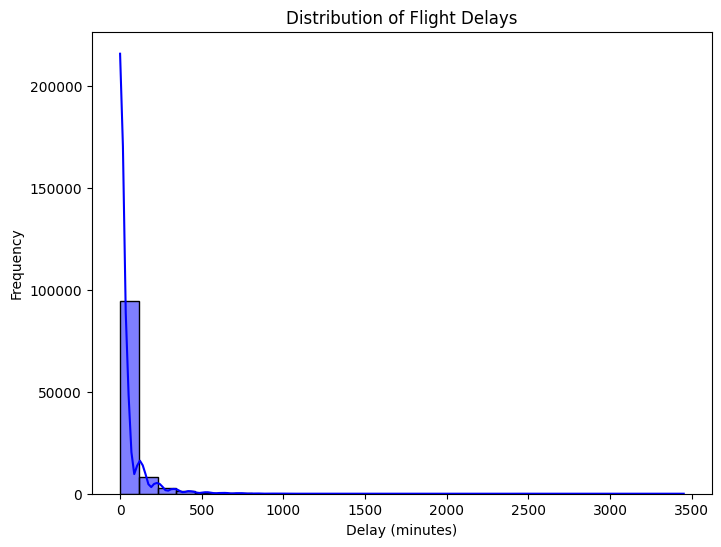

In [12]:
# Distribution of target variable (delays)
plt.figure(figsize=(8, 6))
sns.histplot(y, bins=30, kde=True, color='blue')
plt.title('Distribution of Flight Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.show()


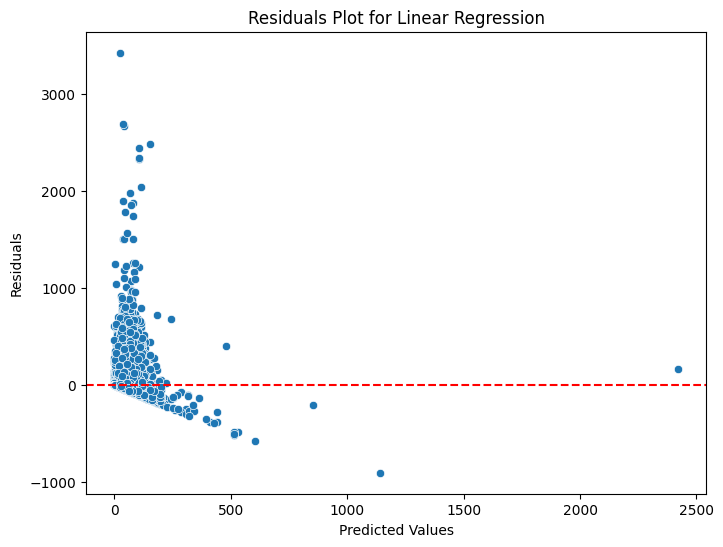

In [13]:

# Residuals for Linear Regression
lr_residuals = y_test - lr_predictions

plt.figure(figsize=(8, 6))
sns.scatterplot(x=lr_predictions, y=lr_residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals Plot for Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


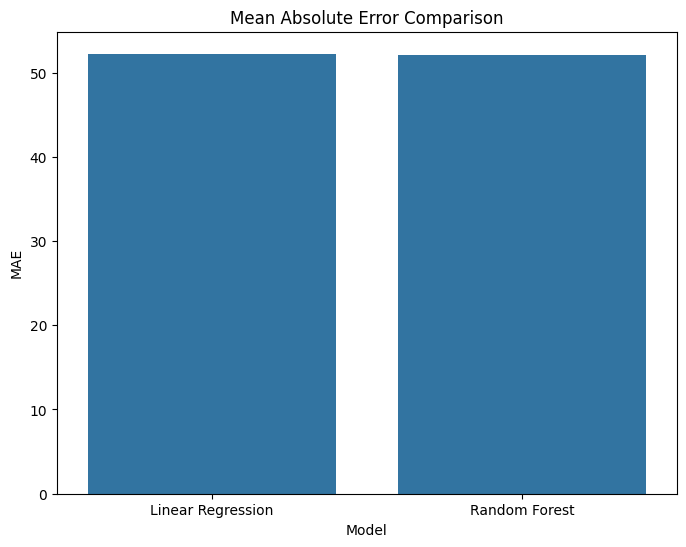

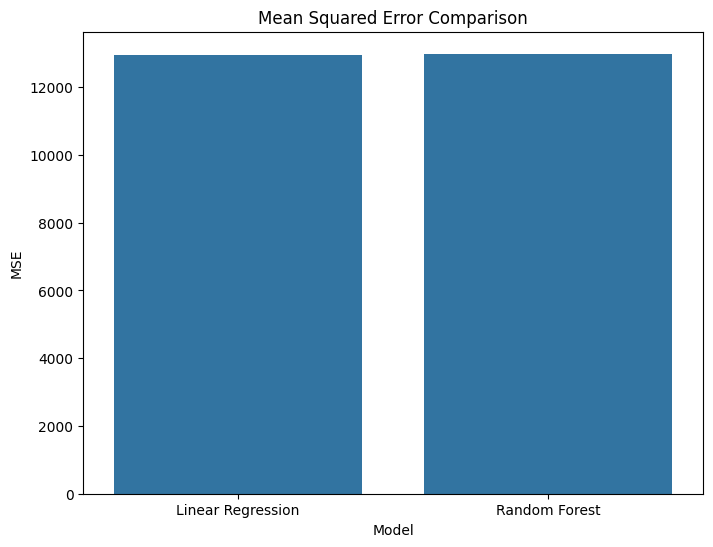

In [15]:
# Create a DataFrame for the metrics
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [mean_absolute_error(y_test, lr_predictions), mean_absolute_error(y_test, rf_predictions)],
    'MSE': [mean_squared_error(y_test, lr_predictions), mean_squared_error(y_test, rf_predictions)],
    'R2 Score': [r2_score(y_test, lr_predictions), r2_score(y_test, rf_predictions)]
})

# Bar plot for MAE
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MAE', data=metrics)
plt.title('Mean Absolute Error Comparison')
plt.show()

# Bar plot for MSE
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MSE', data=metrics)
plt.title('Mean Squared Error Comparison')
plt.show()


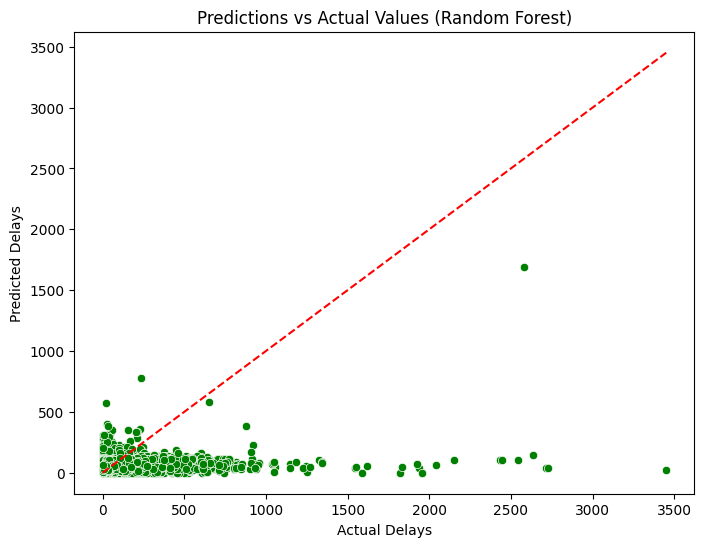

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=rf_predictions, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Perfect prediction line
plt.title('Predictions vs Actual Values (Random Forest)')
plt.xlabel('Actual Delays')
plt.ylabel('Predicted Delays')
plt.show()


# 8. Making Predictions


In [19]:
def predict_flight_delay(lr_model, rf_model, preprocessor):
    # Collect user input
    fltid = input("Enter Flight ID (e.g., 'TU 0712'): ")
    depstn = input("Enter Departure Station (e.g., 'TUN'): ")
    arrstn = input("Enter Arrival Station (e.g., 'CMN'): ")
    
    # You may need to collect other features as well based on your model requirements.
    # Here, we'll assume you're collecting 'FLTID', 'DEPSTN', 'ARRSTN', and we use placeholder values for others.
    new_data = pd.DataFrame({
        'FLTID': [fltid],
        'DEPSTN': [depstn],
        'ARRSTN': [arrstn],
        'day': [1],  # Example placeholder, replace with actual data
        'month': [1],  # Example placeholder, replace with actual data
        'year': [2020],  # Example placeholder, replace with actual data
        # Add more features as required
    })
    
    # Preprocess the new data
    new_data_processed = preprocessor.transform(new_data)

    # Make predictions
    lr_prediction = lr_model.predict(new_data_processed)
    rf_prediction = rf_model.predict(new_data_processed)

    # Output the predictions
    print("Predicted Flight Delay (Linear Regression):", lr_prediction[0],"minutes")
    print("Predicted Flight Delay (Random Forest):", rf_prediction[0],"minutes")

# Example usage:
predict_flight_delay(lr_model, rf_model, preprocessor)


Predicted Flight Delay (Linear Regression): 81.59259631298036 minutes
Predicted Flight Delay (Random Forest): 0.0 minutes
